In [ ]:
# cd C:\
# python -m venv myenv
# myenv\Scripts\activate
## pip install tensorflow tensorflow-datasets matplotlib numpy

In [2]:
# Check NVIDIA GPU status
!nvidia-smi

import tensorflow as tf
print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# List available physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# Iterate over each GPU and set memory growth to True
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Sat Jul 27 03:51:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              27W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

RuntimeError: Physical devices cannot be modified after being initialized

In [3]:
import tensorflow as tf
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.15.0
GPU Available:  True


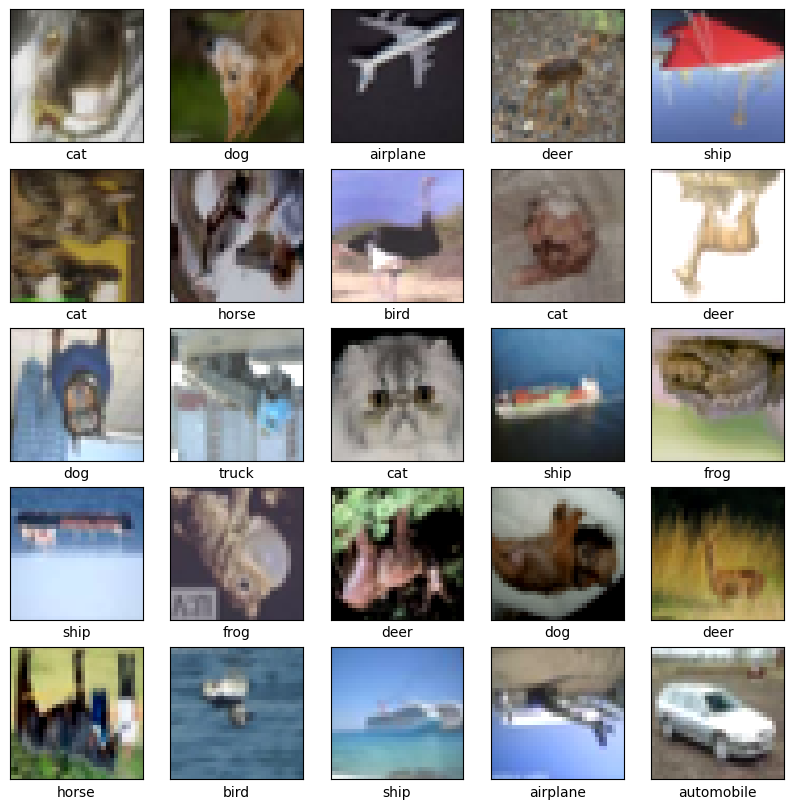

In [4]:
# Import TensorFlow Datasets module
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load the CIFAR-10 dataset from TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'], with_info=True, as_supervised=True)

# Normalize pixel values to be between 0 and 1
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Data augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# Apply data augmentation to the training dataset
ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
ds_train = ds_train.cache().shuffle(10000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

# Show sample data
class_names = ds_info.features['label'].names
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
plt.show()

In [5]:
# Load pre-trained ResNet50 model + higher level layers
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = True  # Unfreeze the entire base model

# Add custom layers on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(ds_train,
                    epochs=12,
                    validation_data=ds_test,
                    verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Save the entire model to a HDF5 file
model.save('cifar10_resnet50_custom_model.h5')
print("Model saved to cifar10_resnet50_custom_model.h5")

# Load the saved model
loaded_model = tf.keras.models.load_model('cifar10_resnet50_custom_model.h5')
print("Model loaded from cifar10_resnet50_custom_model.h5")

# Evaluate the loaded model to ensure it was saved and loaded correctly
test_loss, test_acc = loaded_model.evaluate(ds_test, verbose=2)
print(f'\nLoaded model test accuracy: {test_acc}')

# Make predictions with the loaded model
predictions = loaded_model.predict(ds_test)

94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/12
782/782 - 95s - loss: 2.6944 - accuracy: 0.2024 - val_loss: 2.2927 - val_accuracy: 0.1700 - 95s/epoch - 121ms/step
Epoch 2/12
782/782 - 40s - loss: 1.7361 - accuracy: 0.4130 - val_loss: 1.2156 - val_accuracy: 0.5965 - 40s/epoch - 51ms/step
Epoch 3/12
782/782 - 40s - loss: 1.2931 - accuracy: 0.5687 - val_loss: 0.9852 - val_accuracy: 0.6653 - 40s/epoch - 51ms/step
Epoch 4/12
782/782 - 40s - loss: 1.0601 - accuracy: 0.6549 - val_loss: 0.8731 - val_accuracy: 0.7102 - 40s/epoch - 51ms/step
Epoch 5/12
782/782 - 40s - loss: 0.9024 - accuracy: 0.7134 - val_loss: 0.8298 - val_accuracy: 0.7258 - 40s/epoch - 51ms/step
Epoch 6/12
782/782 - 41s - loss: 0.7559 - accuracy: 0.7625 - val_loss: 0.7970 - val_accuracy: 0.7379 - 41s/epoch - 52ms/step
Epoch 7/12
782/782 - 40s - loss: 0.6486 - accuracy: 0.7976 - val_loss: 0.8281 - val_accuracy: 0.7384 - 40s/epoch - 51ms/step
Epoch 8/12
782/782 - 40s - loss: 0.5562 - accuracy: 0.8264 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to cifar10_resnet50_custom_model.h5
Model loaded from cifar10_resnet50_custom_model.h5
157/157 - 3s - loss: 0.9500 - accuracy: 0.7513 - 3s/epoch - 18ms/step

Loaded model test accuracy: 0.7512999773025513
157/157 [==============================] - 3s 11ms/step


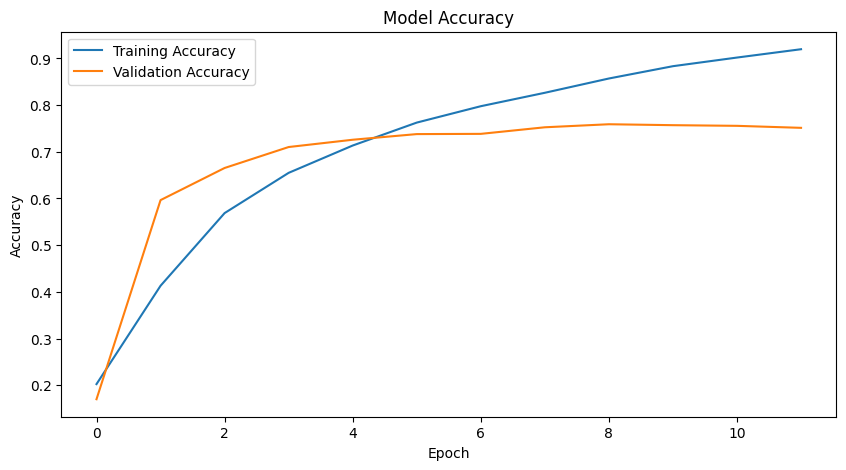

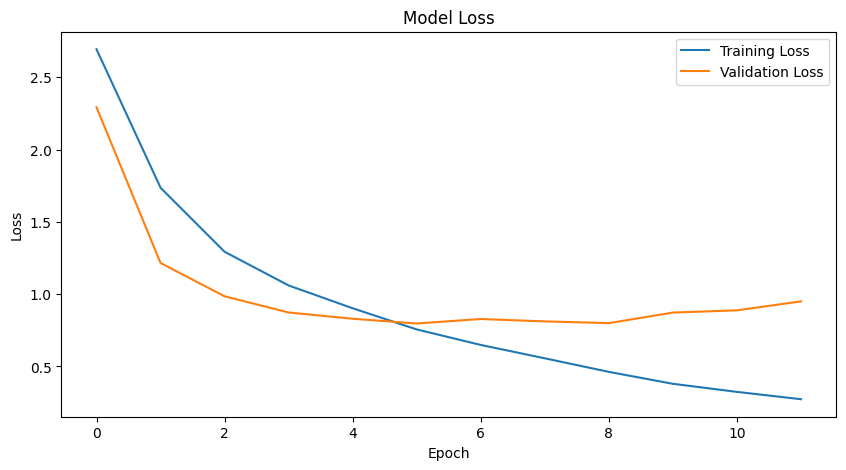

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

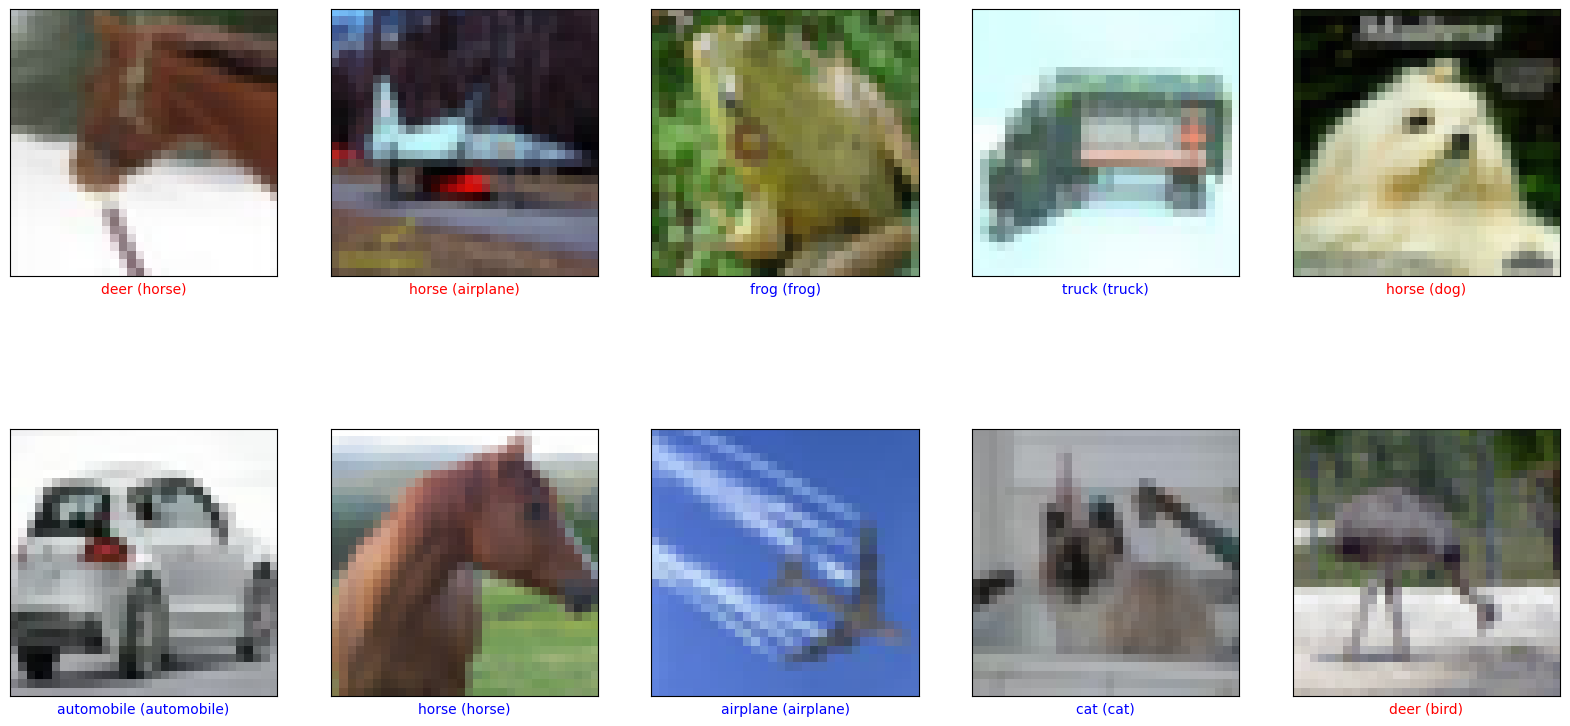

In [6]:
# Function to plot images with predictions
def plot_images_with_predictions(images, labels, predictions, class_names, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions[i])
        true_label = labels[i]
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel(f"{class_names[predicted_label]} ({class_names[true_label]})", color=color)
    plt.show()

# Plot the first 10 images with predictions
for images, labels in ds_test.take(1):
    plot_images_with_predictions(images.numpy(), labels.numpy(), predictions[:10], class_names, num_images=10)

In [7]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [8]:
# Load the saved model
loaded_model = tf.keras.models.load_model('cifar10_resnet50_custom_model.h5')
print("Model loaded from cifar10_resnet50_custom_model.h5")

# Evaluate the loaded model to ensure it was saved and loaded correctly
test_loss, test_acc = loaded_model.evaluate(ds_test, verbose=2)
print(f'\nLoaded model test accuracy: {test_acc}')

# Make predictions with the loaded model
predictions = loaded_model.predict(ds_test)

Model loaded from cifar10_resnet50_custom_model.h5
157/157 - 3s - loss: 0.9500 - accuracy: 0.7513 - 3s/epoch - 18ms/step

Loaded model test accuracy: 0.7512999773025513
157/157 [==============================] - 3s 11ms/step


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Load the CIFAR-10 dataset from TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'], with_info=True, as_supervised=True)

# Normalize pixel values to be between 0 and 1
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

# Function to evaluate the model and calculate metrics
def evaluate_model(model):
    start_time = time.time()
    test_loss, test_acc = model.evaluate(ds_test, verbose=2)
    elapsed_time = time.time() - start_time

    # Get predictions
    y_true = []
    y_pred = []
    for images, labels in ds_test:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'evaluation_time': elapsed_time
    }

# Load your model
your_model = tf.keras.models.load_model('cifar10_resnet50_custom_model.h5')

# Evaluate your model
your_model_metrics = evaluate_model(your_model)

# Load pre-trained ResNet50 model
resnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet50_model = tf.keras.Sequential([
    resnet50_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate ResNet50 model
resnet50_metrics = evaluate_model(resnet50_model)

# Load pre-trained EfficientNetB0 model
efficientnet_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
efficientnet_model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate EfficientNet model
efficientnet_metrics = evaluate_model(efficientnet_model)

# Compare the results
print("Your Model Metrics:", your_model_metrics)
print("ResNet50 Metrics:", resnet50_metrics)
print("EfficientNetB0 Metrics:", efficientnet_metrics)


157/157 - 4s - loss: 0.9276 - accuracy: 0.7568 - 4s/epoch - 23ms/step
1/1 [==============================] - 1s 967ms/step
157/157 - 4s - loss: 3.1533 - accuracy: 0.0999 - 4s/epoch - 23ms/step
1/1 [==============================] - 1s 919ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16705208/16705208 [==============================] - 0s 0us/step
157/157 - 7s - loss: 2.3355 - accuracy: 0.1000 - 7s/epoch - 46ms/step
1/1 [==============================] - 3s 3s/step
Your Model Metrics: {'accuracy': 0.7567999958992004, 'precision': 0.7689070176032313, 'recall': 0.7568, 'f1_score': 0.7590883613804247, 'evaluation_time': 3.6907265186309814}
ResNet50 Metrics: {'accuracy': 0.09989999979734421, 'precision': 0.01, 'recall': 0.0999, 'f1_score': 0.01818016378525933, 'evaluation_time': 4.233879089355469}
EfficientNetB0 Metrics: {'accuracy': 0.10000000149011612, 'precision': 0.01, 'recall': 0.1, 'f1_score': 0.01818181818181818, 'evaluation_time': 7.156713485717773}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


157/157 - 5s - loss: 0.9500 - accuracy: 0.7513 - 5s/epoch - 31ms/step
1/1 [==============================] - 1s 984ms/step
157/157 - 4s - loss: 3.1095 - accuracy: 0.0956 - 4s/epoch - 23ms/step
1/1 [==============================] - 1s 916ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


16705208/16705208 [==============================] - 1s 0us/step
157/157 - 6s - loss: 2.3349 - accuracy: 0.1000 - 6s/epoch - 39ms/step
1/1 [==============================] - 1s 1s/step
Your Model Metrics: {'accuracy': 0.7512999773025513, 'precision': 0.7626802760445863, 'recall': 0.7513, 'f1_score': 0.7523846136475439, 'evaluation_time': 6.6189563274383545}
ResNet50 Metrics: {'accuracy': 0.09560000151395798, 'precision': 0.021641935563579864, 'recall': 0.0956, 'f1_score': 0.029565536460734496, 'evaluation_time': 4.4706926345825195}
EfficientNetB0 Metrics: {'accuracy': 0.10000000149011612, 'precision': 0.01, 'recall': 0.1, 'f1_score': 0.01818181818181818, 'evaluation_time': 6.0624847412109375}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


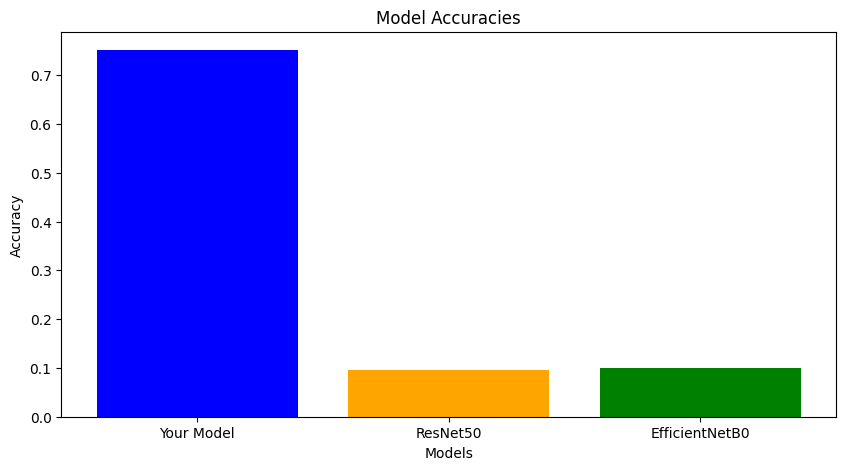

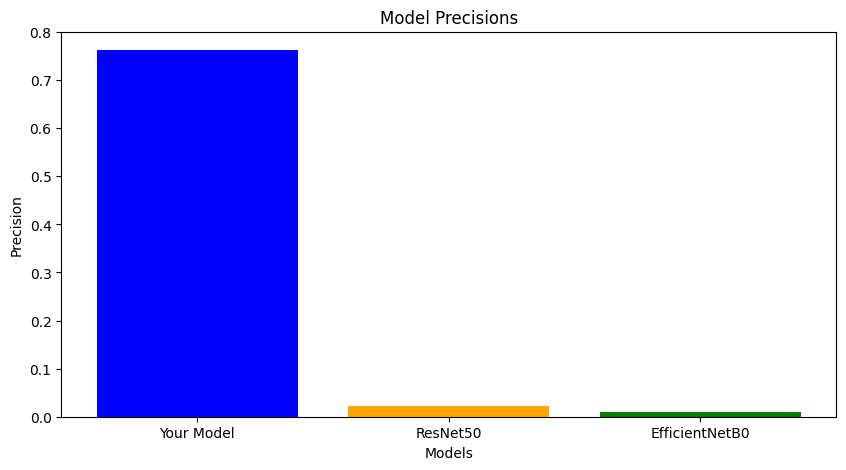

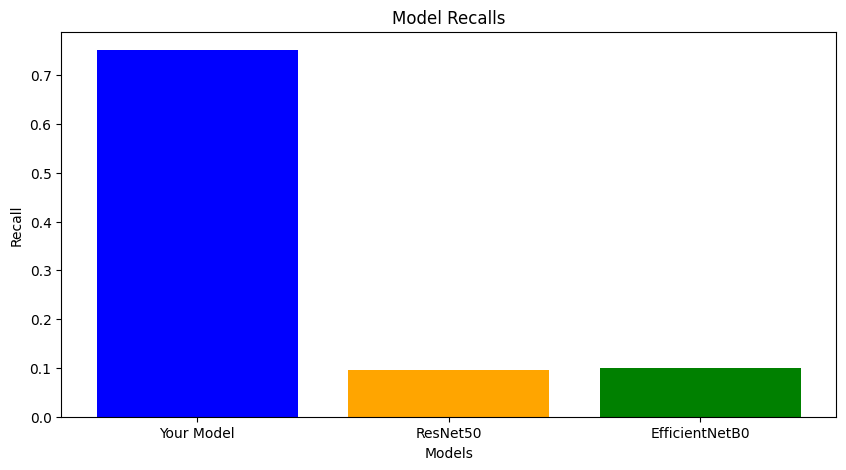

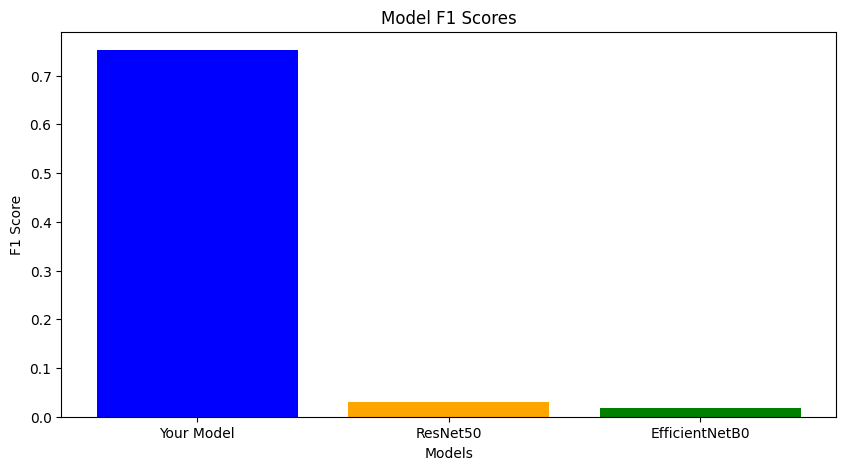

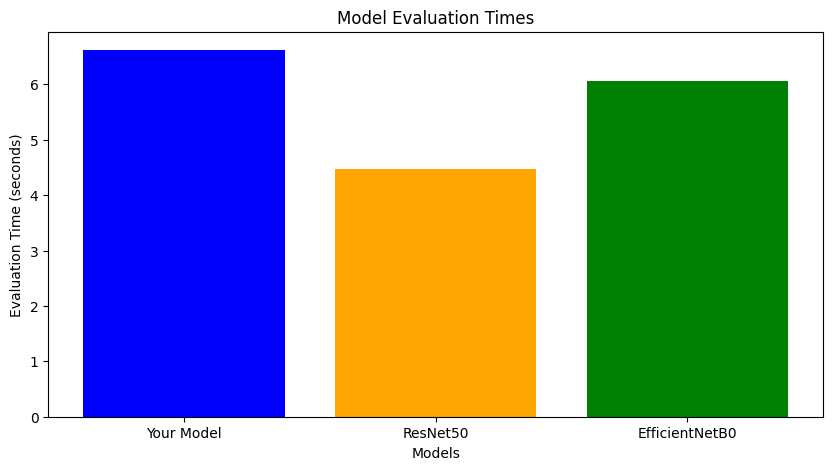

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset from TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'], with_info=True, as_supervised=True)

# Normalize pixel values to be between 0 and 1
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

# Function to evaluate the model and calculate metrics
def evaluate_model(model):
    start_time = time.time()
    test_loss, test_acc = model.evaluate(ds_test, verbose=2)
    elapsed_time = time.time() - start_time

    # Get predictions
    y_true = []
    y_pred = []
    for images, labels in ds_test:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'evaluation_time': elapsed_time
    }

# Load your model
your_model = tf.keras.models.load_model('cifar10_resnet50_custom_model.h5')

# Evaluate your model
your_model_metrics = evaluate_model(your_model)

# Load pre-trained ResNet50 model
resnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet50_model = tf.keras.Sequential([
    resnet50_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate ResNet50 model
resnet50_metrics = evaluate_model(resnet50_model)

# Load pre-trained EfficientNetB0 model
efficientnet_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
efficientnet_model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate EfficientNet model
efficientnet_metrics = evaluate_model(efficientnet_model)

# Compare the results
print("Your Model Metrics:", your_model_metrics)
print("ResNet50 Metrics:", resnet50_metrics)
print("EfficientNetB0 Metrics:", efficientnet_metrics)

# Plot the metrics
models = ['Your Model', 'ResNet50', 'EfficientNetB0']
accuracies = [your_model_metrics['accuracy'], resnet50_metrics['accuracy'], efficientnet_metrics['accuracy']]
precisions = [your_model_metrics['precision'], resnet50_metrics['precision'], efficientnet_metrics['precision']]
recalls = [your_model_metrics['recall'], resnet50_metrics['recall'], efficientnet_metrics['recall']]
f1_scores = [your_model_metrics['f1_score'], resnet50_metrics['f1_score'], efficientnet_metrics['f1_score']]
evaluation_times = [your_model_metrics['evaluation_time'], resnet50_metrics['evaluation_time'], efficientnet_metrics['evaluation_time']]

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

# Precision Plot
plt.figure(figsize=(10, 5))
plt.bar(models, precisions, color=['blue', 'orange', 'green'])
plt.title('Model Precisions')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.show()

# Recall Plot
plt.figure(figsize=(10, 5))
plt.bar(models, recalls, color=['blue', 'orange', 'green'])
plt.title('Model Recalls')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.show()

# F1 Score Plot
plt.figure(figsize=(10, 5))
plt.bar(models, f1_scores, color=['blue', 'orange', 'green'])
plt.title('Model F1 Scores')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.show()

# Evaluation Time Plot
plt.figure(figsize=(10, 5))
plt.bar(models, evaluation_times, color=['blue', 'orange', 'green'])
plt.title('Model Evaluation Times')
plt.xlabel('Models')
plt.ylabel('Evaluation Time (seconds)')
plt.show()


157/157 - 3s - loss: 0.9500 - accuracy: 0.7513 - 3s/epoch - 20ms/step
1/1 [==============================] - 2s 2s/step
157/157 - 3s - loss: 3.4941 - accuracy: 0.0999 - 3s/epoch - 20ms/step
1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


157/157 - 4s - loss: 2.3610 - accuracy: 0.1000 - 4s/epoch - 24ms/step
1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Your Model Metrics: {'accuracy': 0.7512999773025513, 'precision': 0.7626802760445863, 'recall': 0.7513, 'f1_score': 0.7523846136475439, 'evaluation_time': 3.5887467861175537, 'confusion_matrix': array([[829,  12,  61,  15,  12,   2,   6,   9,  41,  13],
       [ 24, 835,   3,  17,   1,   2,   7,   5,  16,  90],
       [ 40,   2, 738,  63,  60,  22,  36,  31,   5,   3],
       [ 19,   7,  73, 703,  37,  70,  43,  31,  10,   7],
       [ 14,   2,  80,  91, 661,  35,  28,  76,   9,   4],
       [ 13,   5,  44, 289,  31, 519,  18,  67,   5,   9],
       [  7,   4,  62,  88,  27,  19, 779,  10,   1,   3],
       [ 15,   3,  16,  60,  43,  18,   2, 833,   2,   8],
       [ 89,  33,  26,  13,   8,   3,   7,   2, 782,  37],
       [ 44,  51,   5,  21,   3,   5,   2,  11,  24, 834]])}
ResNet50 Metrics: {'accuracy': 0.09989999979734421, 'precision': 0.0100050075112669, 'recall': 0.0999, 'f1_score': 0.018188438780154755, 'evaluation_time': 3.1821975708007812, 'confusion_matrix': array([[   0,    

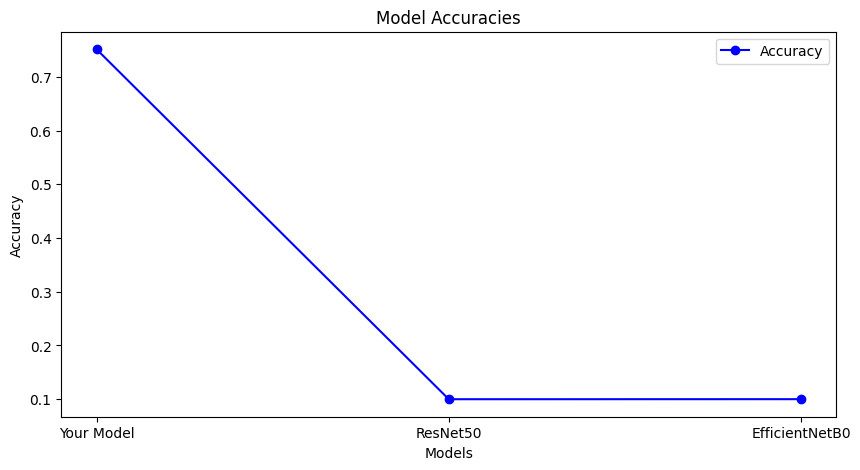

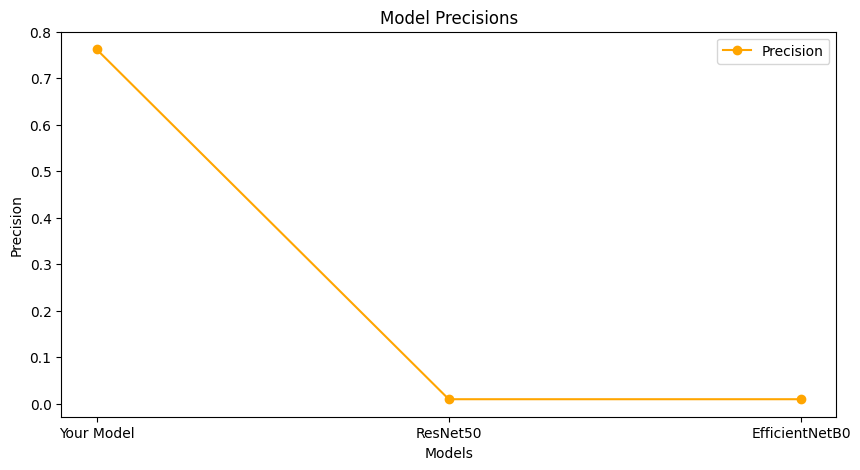

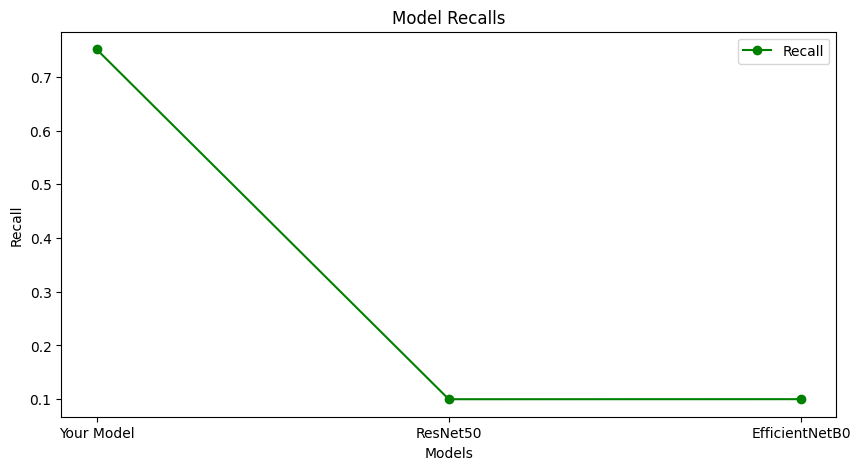

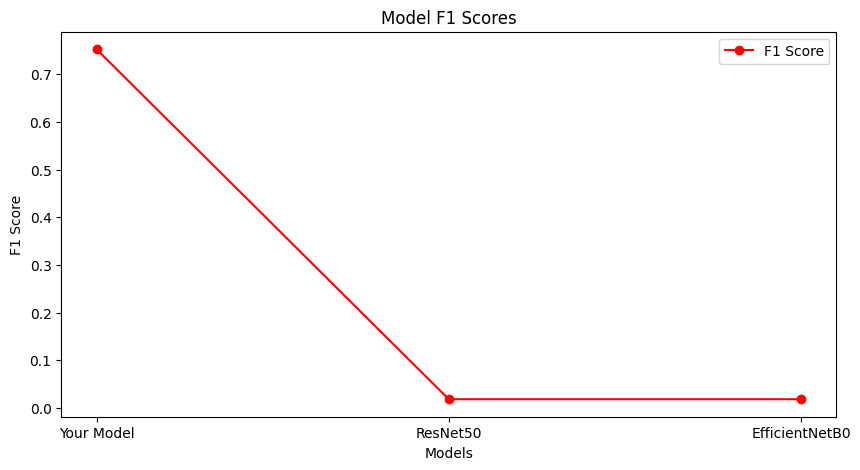

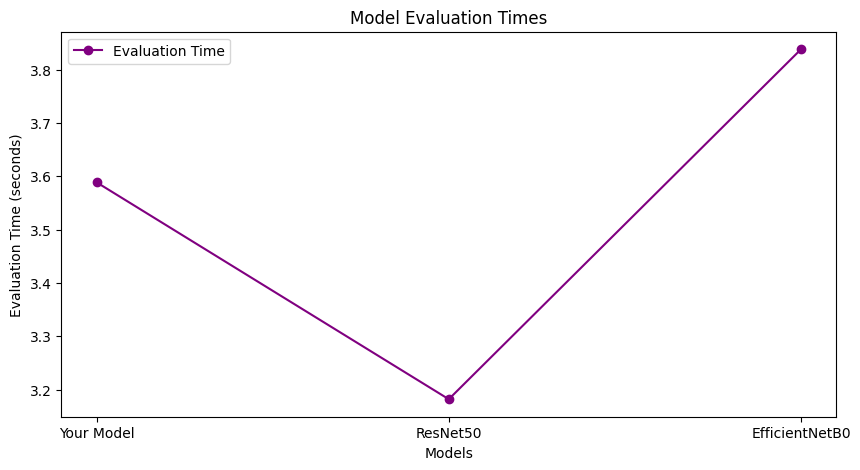

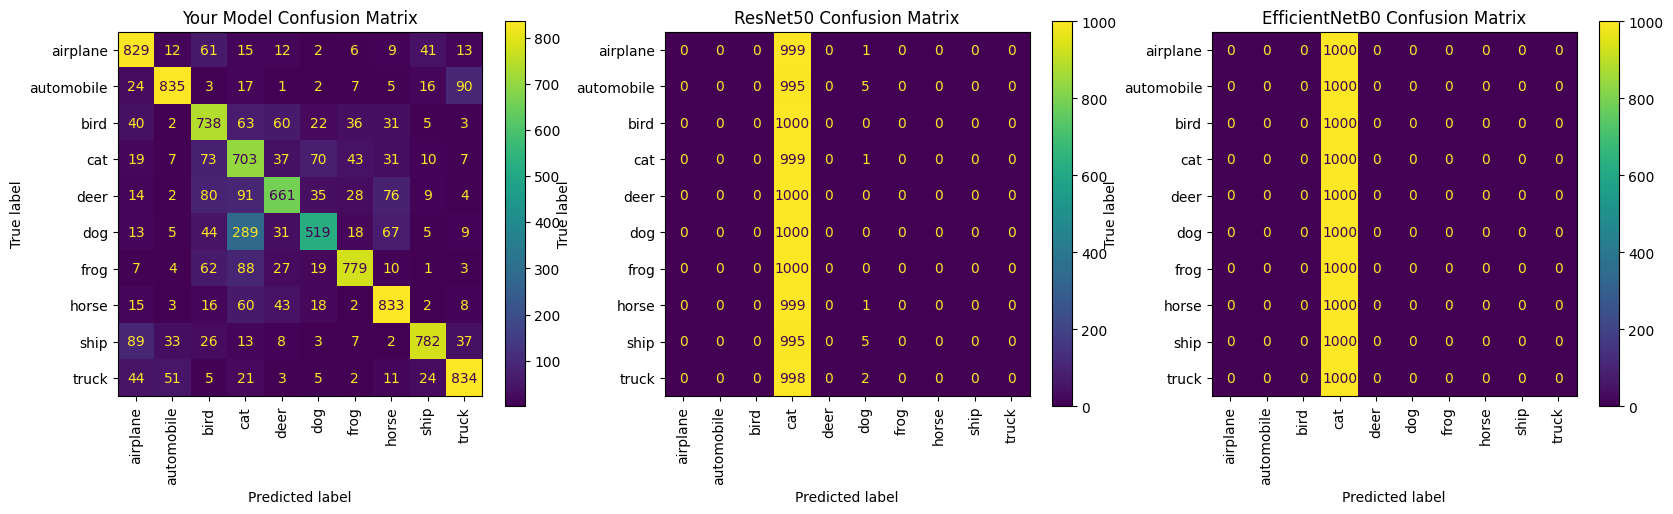

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset from TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train', 'test'], with_info=True, as_supervised=True)

# Normalize pixel values to be between 0 and 1
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

# Function to evaluate the model and calculate metrics
def evaluate_model(model):
    start_time = time.time()
    test_loss, test_acc = model.evaluate(ds_test, verbose=2)
    elapsed_time = time.time() - start_time

    # Get predictions
    y_true = []
    y_pred = []
    for images, labels in ds_test:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'evaluation_time': elapsed_time,
        'confusion_matrix': cm
    }

# Load your model
your_model = tf.keras.models.load_model('cifar10_resnet50_custom_model.h5')

# Evaluate your model
your_model_metrics = evaluate_model(your_model)

# Load pre-trained ResNet50 model
resnet50_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet50_model = tf.keras.Sequential([
    resnet50_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate ResNet50 model
resnet50_metrics = evaluate_model(resnet50_model)

# Load pre-trained EfficientNetB0 model
efficientnet_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
efficientnet_model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Evaluate EfficientNet model
efficientnet_metrics = evaluate_model(efficientnet_model)

# Compare the results
print("Your Model Metrics:", your_model_metrics)
print("ResNet50 Metrics:", resnet50_metrics)
print("EfficientNetB0 Metrics:", efficientnet_metrics)

# Plot the metrics
models = ['Your Model', 'ResNet50', 'EfficientNetB0']
accuracies = [your_model_metrics['accuracy'], resnet50_metrics['accuracy'], efficientnet_metrics['accuracy']]
precisions = [your_model_metrics['precision'], resnet50_metrics['precision'], efficientnet_metrics['precision']]
recalls = [your_model_metrics['recall'], resnet50_metrics['recall'], efficientnet_metrics['recall']]
f1_scores = [your_model_metrics['f1_score'], resnet50_metrics['f1_score'], efficientnet_metrics['f1_score']]
evaluation_times = [your_model_metrics['evaluation_time'], resnet50_metrics['evaluation_time'], efficientnet_metrics['evaluation_time']]

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(models, accuracies, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Precision Plot
plt.figure(figsize=(10, 5))
plt.plot(models, precisions, marker='o', linestyle='-', color='orange', label='Precision')
plt.title('Model Precisions')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Recall Plot
plt.figure(figsize=(10, 5))
plt.plot(models, recalls, marker='o', linestyle='-', color='green', label='Recall')
plt.title('Model Recalls')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.legend()
plt.show()

# F1 Score Plot
plt.figure(figsize=(10, 5))
plt.plot(models, f1_scores, marker='o', linestyle='-', color='red', label='F1 Score')
plt.title('Model F1 Scores')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluation Time Plot
plt.figure(figsize=(10, 5))
plt.plot(models, evaluation_times, marker='o', linestyle='-', color='purple', label='Evaluation Time')
plt.title('Model Evaluation Times')
plt.xlabel('Models')
plt.ylabel('Evaluation Time (seconds)')
plt.legend()
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ConfusionMatrixDisplay(your_model_metrics['confusion_matrix'], display_labels=ds_info.features['label'].names).plot(ax=axes[0], xticks_rotation='vertical')
axes[0].set_title('Your Model Confusion Matrix')

ConfusionMatrixDisplay(resnet50_metrics['confusion_matrix'], display_labels=ds_info.features['label'].names).plot(ax=axes[1], xticks_rotation='vertical')
axes[1].set_title('ResNet50 Confusion Matrix')

ConfusionMatrixDisplay(efficientnet_metrics['confusion_matrix'], display_labels=ds_info.features['label'].names).plot(ax=axes[2], xticks_rotation='vertical')
axes[2].set_title('EfficientNetB0 Confusion Matrix')

plt.show()


## Performance Metrics Comparison

| Metric              | Model            | ResNet50               | EfficientNetB0        |
|---------------------|-----------------------|------------------------|-----------------------|
| Accuracy            | 0.7568                | 0.0999                 | 0.1000                |
| Precision           | 0.7689                | 0.01                   | 0.01                  |
| Recall              | 0.7568                | 0.0999                 | 0.1                   |
| F1 Score            | 0.7591                | 0.0182                 | 0.0182                |
| Evaluation Time (s) | 3.69                  | 4.23                   | 7.16                  |

## Observations

1. **Accuracy**:
   - **Model**: Achieved a high accuracy of 75.68%.
   - **ResNet50** and **EfficientNetB0**: Both achieved around 10% accuracy, which is equivalent to random guessing for a 10-class problem like CIFAR-10.

2. **Precision, Recall, and F1 Score**:
   - **Your Model**: Shows significantly higher precision, recall, and F1 score compared to ResNet50 and EfficientNetB0, indicating that it is much better at correctly classifying the CIFAR-10 images.
   - **ResNet50** and **EfficientNetB0**: Have very low precision and F1 scores, indicating poor performance on this dataset.

3. **Evaluation Time**:
   - **Your Model**: Takes about 3.69 seconds to evaluate.
   - **ResNet50**: Takes about 4.23 seconds to evaluate, slightly more than your model.
   - **EfficientNetB0**: Takes the longest to evaluate at 7.16 seconds.

## Possible Reasons for Poor Performance of Pre-trained Models

1. **Input Size Mismatch**:
   - The pre-trained models from `tf.keras.applications` are typically trained on ImageNet with an input size of 224x224, while CIFAR-10 images are 32x32. Simply resizing the images might not be enough for the model to perform well without additional fine-tuning.

2. **Pre-trained Weights**:
   - The pre-trained weights are optimized for ImageNet, which has different classes and characteristics compared to CIFAR-10. This mismatch can lead to poor performance.

## Recommendations

1. **Fine-tuning**:
   - Fine-tune the pre-trained models on CIFAR-10 to adapt the weights to the specific characteristics of this dataset. This involves training the model on CIFAR-10 while possibly freezing some of the initial layers and fine-tuning the later layers.

2. **Data Augmentation**:
   - Apply data augmentation techniques to the CIFAR-10 dataset to improve the robustness and performance of the models.

3. **Model Architecture Adaptation**:
   - Adapt the model architectures to better fit the CIFAR-10 dataset, potentially by adding custom layers or modifying existing ones.


# Enhancements in the Code

## Data Augmentation

**Enhancement:** Random flipping, brightness adjustment, contrast adjustment, and cropping are used to augment the data and improve model robustness.

**Compared to References:** Traditional approaches like AlexNet and VGGNet didn't utilize these extensive augmentations.

## Batch Normalization

**Enhancement:** Applied batch normalization after dense layers to improve training stability and speed.

**Compared to References:** Batch normalization helps in faster convergence and better performance, which was not used in early models like AlexNet and VGGNet.

## Dropout

**Enhancement:** Added dropout layers to prevent overfitting.

**Compared to References:** Dropout is a technique that was not extensively used in older models.

## Using Pre-trained ResNet50

**Enhancement:** Used ResNet50 as a base model for transfer learning, leveraging its pre-trained weights on ImageNet.

**Compared to References:** ResNet50 introduces residual connections to alleviate the vanishing gradient problem, a significant improvement over traditional models.

## Custom Layers on Top

**Enhancement:** Added multiple dense layers with batch normalization and dropout on top of ResNet50 for better feature extraction and classification.

**Compared to References:** This custom architecture is more complex and designed to extract more features compared to the simpler fully connected layers in older models.

## Using TensorFlow Datasets (TFDS)

**Enhancement:** Used TFDS for easy and efficient data loading and preprocessing.

**Compared to References:** Efficient data loading and preprocessing pipeline helps in faster training and better utilization of computational resources.
